# Data Scientist Assignment


In this task, you will work with a sample dataset containing ad impression and click data.

The primary objective of this assignment is to analyze the data, derive meaningful insights, and build predictive models based on the patterns you uncover, to ultimatly improve click prediction.


# 0. Data Description


The dataset provided has been undersampled to ensure that clicks represent 5% of the total data, as opposed to the original 0.4%. It consists of one week of advertising data from Finland where one row represents an ad impression (view). The data includes the following features:

- Label: A binary feature indicating whether the ad was clicked (1) or not (0).
- art: The ad ID.
- loc: The site ID, representing the website where the ad appeared.
- tag: The placement ID assigned by the site to indicate the ad slot on the site where the ad was shown.
- dt: The device type on which the ad was displayed (mobile, tablet, or desktop).
- type: The type of advertisement, either banner or native.
- os: The operating system of the device.
- lt: The local time when the ad was displayed.
- make: The make (manufacturer) of the device.
- client: The client ID representing the advertiser.
- lang: The language of the browser.
- cl: The number of clicks the ad has received.


## 1. Loading the data & exploration


In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
import pandas as pd
from pycaret.classification import *
import category_encoders as ce
from utils import *

warnings.filterwarnings("ignore")
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

N = 10

# Load dataset:
df = pd.read_feather("readpeak_data.feather")
df.head()

,art,loc,tag,dt,type,os,lt,make,client,city,lang,cl,label
9037056,6cb6aadc,4be84111,95e44e1c,mobile,native,Android,2022-06-10T01:56:49.332Z,Samsung,3234052e,eb1c296c,en,72,0
1493784,d7ac4cc4,a9346b00,c138f7fa,desktop,native,None,2022-06-12T09:32:13.555Z,None,79e89163,aa56ab48,None,467,0
6637725,9c1ddd84,be4b2f45,6438275c,desktop,native,None,2022-06-07T18:04:11.615Z,None,ae8046da,0cf4e8a7,None,27,0
1781706,00b396ac,68e476b5,0ed73eeb,desktop,native,None,2022-06-08T10:04:41.808Z,None,ae8046da,None,None,519,0
17525502,426595c6,5d389f5e,21c6d6a0,mobile,native,AndroidOS,2022-06-11T13:07:09.077Z,GenericPhone,5f96ea9c,ce81d3d8,None,84,0


### 1.1. Data Cleaning


### What potential challenges can you identify from the given data? and give a brief explanation how you would address them?


Let's first remove all duplicate data. We can see that there are only 113 duplicated rows, which is very small compared to the total rows.


In [2]:
# Remove duplicates:
print(f"Number of duplicates: {df.duplicated().sum()} / {len(df)}")
df = df.drop_duplicates()

Number of duplicates: 113 / 1523340


Next some light preprocessing:

- Convert datetime column **lt** to datetime type.
- For string type columns, lowercase and strip whitespace for them.
- Ensure **tag** id is unique across **loc** site, because some sites assign same tag id for total different tags. Probably because they are not aware of each others systems.


In [3]:
# Ensure correct data types:
df["lt"] = pd.to_datetime(df["lt"].map(lambda t: t.split(".")[0]))

# Lowercase and strip whitespace all string columns:
df = df.applymap(lambda s: s.lower().strip() if type(s) == str else s)

# Ensure "tag" is unique across "loc":
df["_tag"] = df["tag"]
df["tag"] = df["tag"] + "-" + df["loc"]

We then normalize some of the columns. In particular:

- **os**: Similar os type such as "apple ios", "ipados", "ios" will be normalized to just "ios".
- **lang**: Language "en-us" or "sv-se" should be normalized to "en" or "sv" respectively.
- **make**: "samsungtablet" or "huaweitablet" will have "tablet" removed because this information is in **dt** column. Value like "iphone", "mac", etc will be normalized to "apple" because they are all manufactored by "apple".


In [4]:
# Normalize "os", "lang", and "make":
df["os"] = df["os"].apply(normalize_os)
df["lang"] = df["lang"].apply(normalize_lang)
df["make"] = df["make"].apply(normalize_make)

Now we will handle missing data. We first plot the percentage of missing values and value frequency distribution for each columns.


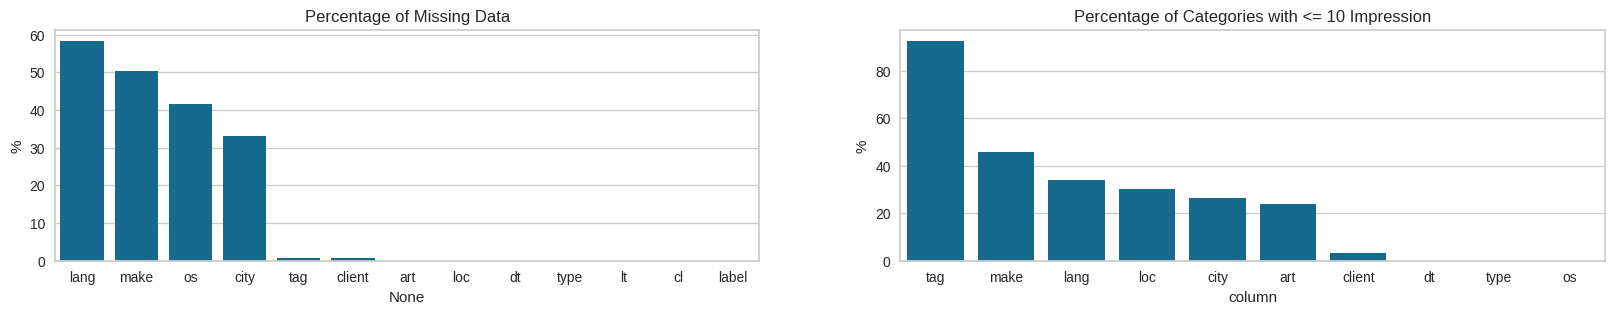

In [5]:
# Plot percentage of missing data:
missings = (
    (df.drop("_tag", axis=1).isnull().mean() * 100)
    .round(2)
    .sort_values(ascending=False)
)
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax[0].set_title("Percentage of Missing Data")
ax[0].set_ylabel("%")
sns.barplot(x=missings.index, y=missings.values, ax=ax[0])


# Function to calculate percentages of categories with counts less than 10
def calculate_percentage(column):
    value_counts = column.value_counts()
    count_less_than_10 = 100 * len(value_counts[value_counts <= 10]) / len(value_counts)
    return count_less_than_10


percentage_df = (
    df.drop("_tag", axis=1)
    .select_dtypes(include="object")
    .apply(calculate_percentage)
    .reset_index()
)
percentage_df.columns = ["column", "percentage"]
percentage_df = percentage_df.sort_values(by="percentage", ascending=False)
sns.barplot(x="column", y="percentage", data=percentage_df, ax=ax[1])
ax[1].set_title("Percentage of Categories with <= 10 Impression")
ax[1].set_ylabel("%")
plt.show()

# Create tab widget
tab = widgets.Tab()
contents = []

columns = list(missings.loc[missings > 0].index)
for column in columns:
    # Create an output widget for each plot
    output = widgets.Output()

    with output:
        fig, ax = plt.subplots(figsize=(10, 3))
        sns.countplot(
            data=df,
            x=column,
            order=df[column].value_counts().nlargest(50).index,
            ax=ax,
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_title(f"{column.capitalize()} Total Impressions", fontsize=16)
        plt.show()

    # Append the output widget to the outputs list
    contents.append(output)

# Set the tab children to the list of outputs
tab.children = contents
tab.titles = columns

# Display the tab widget
display(tab)

From the plot, we can see that:

- Almost 60% of **"lang"** are missing, and it's heavily skewed to **fi**. The data are collected in Finland, so it's very likely that the missing values are mostly **fi**. There is also no information about the language of the ads, so imputing those missing values probably won't help much for the prediction -> Drop **lang** column.
- **"make"** also has large missing percentage. I believe that **os** and **dt** are closely related to **make**. Chi-Square Test for Independence can be used to check it -> Drop **make** column.
- **"os"**, **"city"**, **"client"**, **"tag"** missing values will be imputed with **unknown**.
- Lots of categories in each column have a minimal number of impressions. One option is replacing those rare categories with **others**, which might affect the analysis. This will be taken care of later when we deal with categorical encoding.


In [6]:
# Drop "lang" column:
df = df.drop(["lang", "make"], axis=1)

# Impute missing values with "unknown":
df = df.fillna("unknown")
df["tag"] = df["_tag"] + "-" + df["loc"]
df = df.drop("_tag", axis=1)

In [7]:
# Reset index:
df.reset_index(drop=True, inplace=True)

# Keep a copy of processed dataframe:
_df = df.copy(deep=True)

### 1.2 Exploratory Data Analysis


#### 1.2.1 Total Impressions vs CTR

Let's first understand the relationship between the number of impressions of each category and Click Through Rate (% CTR). From the visualization we can see that:

- CTRs of categories of **art**, **loc**, **tag**, **client** vary significantly. Some of them even go up to 20%, which might indicate that they are:
  - **loc**: site that is very good at showing ads
  - **tag**: page that goes very well with ads
  - **client**: client that has several successful campaigns
  - **art**: ads that is very attractive and performant
- CTRs of **dt**, **type**, **os**, **city** doesn't seem to vary much. Those of **city** are even plateau. This might indicate that these columns are not strong predictors for CTR.

**Note**: I believe the given data contains only impression that Readpeak bidded successfully. This is not the actually the total impressions that hit Readpeak's system. Won impressions can still be a good proxy of the total incoming impressions though.

**CTR Calculation**: Using Bayesian estimation, I calculate CTR by posterior mean of a binomial distribution with beta prior $Beta(\alpha, \beta)$. Given the CTR is usually around 0.4%, the formula is:

$$
CTR = 100 * \frac{\alpha + clicks}{\alpha + \beta + impressions}, where \{^{\alpha = 4}_{\beta = 996}
$$


In [8]:
from utils import *

columns = list(df.drop(["lt", "label", "cl"], axis=1).columns)

# Create tab widget
tab = widgets.Tab()
contents = []

for i, column in enumerate(columns):
    fig = plot_category_vs_ctr(df, column, 50)
    output = widgets.Output()
    with output:
        display(fig)
    contents.append(output)

# Set the tab children to the list of outputs
tab.children = contents
tab.titles = columns

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Total Impressions vs CTR</h1>"), tab]))

#### NOTICE: The next code block might take a few minutes to finish the visualization. This could be improved by making it renders more lazily.

#### 1.2.2 Ads Performance

Next let's visualize how and ad's total impressions and performance CTR change over time. Each **art** tab is an ad performance across all **tag**, and also the breakdown of performance per tag id, overall **tag** overall performance and **loc** overall performance. Here are some observations:

- Ads tends to have higher CTR in **tag** placements which have higher impression and CTR
- Some ads have high CTR, but their CTRs decrease over time. This might indicate that people are less likely to click on the same ads displayed in the same place if they have seen it before.
- Some clear seasonal trends in the amount of impressions and CTR from the site and placement. There are more impressions at certain hours than others, especially from 6AM to 12AM. Maybe these sites are newspapers.
- Whether a day is weekday or weekend doesn't seem to affect the amount of impressions and CTR.
- Some pairs seem to perform consistently whenever the ads are displayed in the same place.

From there, I believe that hour of the day, hourly/cumulative impressions/CTR in that hour can be additional features because they inform about the amount of traffic a site or placement receives at a particular time.


In [9]:
from utils import *

# Create a tab widget
tab = widgets.Tab()
tab_contents = []

# # Loop through each 'loc' id and create a tab for each one
art_ids = select_for_plot(df, "art", N)
for art_id in art_ids:
    art_content = create_content(df, art_id)

    # Create a 'tag' tab for each art id
    tag_tab = widgets.Tab()
    tag_contents = []

    tag_ids = select_for_plot(filter_df(df, {"art": art_id}), "tag", N)
    for tag_id in tag_ids:
        tag_content = create_content(df, art_id, tag_id)
        tag_contents.append(tag_content)
    tag_tab.children = tag_contents
    tag_tab.titles = tag_ids

    # Add the layout to the tab contents
    tab_contents.append(
        widgets.VBox(
            [
                art_content,
                widgets.HTML(value="<h2>Ad Performance Per Tag</h2>"),
                tag_tab,
            ]
        )
    )

# # Set up the tabs in the widget
tab.children = tab_contents
tab.titles = art_ids

# Display the tab widget
display(widgets.VBox([widgets.HTML(value="<h1>Overall Ad Performance</h1>"), tab]))

# 2. Feature Engineering


### Create at least two new features from the existing data.


In [10]:
from utils import *

df = _df.copy(deep=True)

# Create "Hour" feature:
df["hour"] = df["lt"].dt.hour

# Create "Art-Tag Cumulative CTR" feature:
df["art_tag"] = df["art"] + "-" + df["tag"]
df = df.sort_values(by=["art_tag", "lt"])
df["art_tag_cumu_ctr"] = posterior_ctr(
    df.groupby("art_tag")["label"].cumsum().shift(1, fill_value=0),
    (df.groupby("art_tag").cumcount() + 1).shift(1, fill_value=0),
)
df = df.drop(columns=["art_tag"])

# Create "Tag Hourly Impression" feature:
df = df.sort_values(["tag", "lt"])
df["tag_hourly_impressions"] = (
    df.groupby("tag")
    .apply(
        lambda group: group[["tag", "lt"]]
        .rolling("1H", on="lt")
        .count()["tag"]
        .shift(1, fill_value=0)
    )
    .reset_index(level=0, drop=True)
)

# Create "Tag Hourly CTR" feature:
df = df.sort_values(["tag", "lt"])
df["tag_hourly_clicks"] = (
    df.groupby("tag")
    .apply(
        lambda group: group[["label", "lt"]]
        .rolling("1H", on="lt")
        .sum()["label"]
        .shift(1, fill_value=0)
    )
    .reset_index(level=0, drop=True)
)
df["tag_hourly_ctr"] = posterior_ctr(
    df["tag_hourly_clicks"], df["tag_hourly_impressions"]
)
df = df.drop("tag_hourly_clicks", axis=1)

#### What new features did you create and why?

From the analysis, the following features are worth adding to improve click prediction:

- **Hour**: CTR varies significantly by the hour of the day, making the hour of impression a useful predictor. This can be easily derived from the timestamp.
- **Tag Hourly Impressions** and **Tag Hourly CTR**: Higher overall **tag** impressions and CTR tend to lead to higher **art** CTR. High **tag** impressions but low CTR tend to yield low **art** CTR. These features basically tell the overall value of the **tag**. Those of **loc** seem to be not suitable because they provide too coarse information.
- **Art-Tag Cumulative CTR**: This feature tracks the cumulative performance of an **art** on a specific **tag**. Increasing **art** cumulative CTR indicates it is more likely to continue to be clicked.


#### How do you expect these features to improve the performance of a machine learning model?

These new features are expected to enhance the machine learning model's performance by providing richer context and capturing more detailed patterns in ad engagement:

- **Hour**: Click behavior often varies by time of day. Adding the Hour feature helps the model detect temporal trends, improving its ability to predict clicks based on user activity at different times.
- **Tag Hourly Impressions** and **Tag Hourly CTR**: These features reveal the effectiveness of specific ad placements over time. They allow the model to learn which slots have more impression, and are more likely to result in clicks.
- **Art-Tag Cumulative CTR**: Tracking the cumulative performance of an ad in specific placements provides historical context, helping the model predict future clicks based on long-term trends.


#### What kind of external data could be used to improve the predictive performance of the ML model?

External data that adds semantic context and enriches metadata about the site, ad placement, client, and ad content can be valuable. Here are some potential additional features:

- **Site-related**: Site category (e.g., news, e-commerce), site popularity, content genre, typical user demographics.
- **Ad placement**: Page content (headline/theme), position on page (above/below fold), page engagement (time spent, bounce rate).
- **Client-related**: Advertiser industry, brand awareness, historical ad performance.
- **Ad content**: Theme or product promoted, ad sentiment, visual attributes, and target audience alignment.


# 3. Model selection and building


### The goal of the model is to predict the likelyhood of a click


#### Train/Val/Test Splits

- Let's first experimenting with just 0.1% of the original data for model selection and hyperparameter tuning. After that we can split train-val (70%), test (30%) as usual for final model.
- Also, we will try first with the original features without those added from feature engineer steps. Then we can try adding them later.
- Dataset will be split based on time, that is, we use data at the beginning of the week to train models and predict for the rest of the week.


In [11]:
# Set seed for reproducibility:
seed = 42

df = _df.sort_values(by="lt").drop(["lt"], axis=1).drop_duplicates()
split_index = int(len(df) * 0.001)

df_train, df_test = df.iloc[:split_index], df.iloc[split_index:]

#### Categorical Encoding

In out dataset, features **art**, **loc**, **tag**, **client**, **city** have high cardinality, making **OneHotEncoder** unsuitable, because the data matrix will be very sparse and memory intensive. We will experiment with **HashingEncoder**, **LeaveOneOutEncoder**.

- **HashingEncoder**: The choice of number of components follows the recommendations from [Lucas Bernardi](https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087), that is, $20 * features$
- **LeaveOneOutEncoder**: One modification I made is that instead of simply compute the mean of target as the encoding (which is also %CTR), I use the posterior estimation of CTR. The reason is that some categories is very rare but still have clicks, naive CTR would make the numerical encoding very high, which might not reflect the true characteristic of the category. Collisions will probably happen for rare categories. This is maybe desired because for the model, rare categories can be treated indifferently; if they are rare then the chance the ads get clicked is also small. This is like converting those rare categories to "others".


In [12]:
encoders = {
    "Hashing": ce.HashingEncoder(n_components=160),
    "Leave One Out": CTRLeaveOneOutEncoder(),
}

#### Model Training

For convenient experimentation, I will utilize [Pycaret](https://pycaret.readthedocs.io/en/latest/index.html) library to conduct many experiments to compare several models' performance. This might take a couple of minutes so please wait. Set the flag **use_gpu=True** for speedup.


In [13]:
!pip install pycaret -q
for name, encoder in encoders.items():
    print(f"Run Pycaret With {name} Encoder")
    setup(
        data=df_train,
        target="label",
        train_size=0.5,
        fix_imbalance=False,
        max_encoding_ohe=0,
        encoding_method=encoder,
        normalize=True,
        normalize_method="zscore",
        session_id=seed,
        fold=5,
        use_gpu=False,
    )

    best = compare_models(exclude=["knn", "lightgbm"], sort="F1", n_select=1)
    print(f"Test Best Model On Hold-out Test Dataset")
    predict_model(best, data=df_test)
    print("\n\n")

Run Pycaret With Hashing Encoder


,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Original data shape,"(826, 10)"
4,Transformed data shape,"(826, 163)"
5,Transformed train set shape,"(413, 163)"
6,Transformed test set shape,"(413, 163)"
7,Numeric features,1
8,Categorical features,8
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.7724,0.7127,0.6389,0.2494,0.3575,0.2480,0.2929,0.8440
lda,Linear Discriminant Analysis,0.8014,0.6537,0.3000,0.2129,0.2360,0.1316,0.1393,0.1600
svm,SVM - Linear Kernel,0.8353,0.7201,0.1417,0.2139,0.1503,0.0653,0.0760,0.1520
et,Extra Trees Classifier,0.8547,0.4816,0.0889,0.1667,0.1112,0.0400,0.0449,0.3060
rf,Random Forest Classifier,0.8547,0.6336,0.0889,0.1778,0.1111,0.0409,0.0482,0.3060
dt,Decision Tree Classifier,0.8208,0.4998,0.0889,0.0927,0.0880,-0.0091,-0.0088,0.1420
ada,Ada Boost Classifier,0.8426,0.6643,0.0694,0.0697,0.0686,-0.0052,-0.0105,0.2100
gbc,Gradient Boosting Classifier,0.8401,0.6737,0.0444,0.1182,0.0564,-0.0192,-0.0126,0.2460
xgboost,Extreme Gradient Boosting,0.8450,0.6610,0.0444,0.0889,0.0556,-0.0167,-0.0168,0.2940
ridge,Ridge Classifier,0.8403,0.6598,0.0500,0.0444,0.0471,-0.0288,-0.0342,0.1620


Test Best Model On Hold-out Test Dataset


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8707,0.5142,0.0900,0.1127,0.1001,0.0314,0.0316





Run Pycaret With Leave One Out Encoder


,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Original data shape,"(826, 10)"
4,Transformed data shape,"(826, 10)"
5,Transformed train set shape,"(413, 10)"
6,Transformed test set shape,"(413, 10)"
7,Numeric features,1
8,Categorical features,8
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3200
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1940
catboost,CatBoost Classifier,0.9952,1.0000,0.9528,1.0000,0.9749,0.9722,0.9731,1.3240
rf,Random Forest Classifier,0.9928,1.0000,0.9333,1.0000,0.9600,0.9562,0.9601,0.4680
xgboost,Extreme Gradient Boosting,0.9903,1.0000,0.9056,1.0000,0.9464,0.9412,0.9450,0.1100
et,Extra Trees Classifier,0.9879,0.9997,0.8806,1.0000,0.9331,0.9265,0.9308,0.2120
dt,Decision Tree Classifier,0.9855,0.9403,0.8833,0.9800,0.9228,0.9150,0.9202,0.1960
qda,Quadratic Discriminant Analysis,0.4598,0.6827,0.7861,0.1455,0.2395,0.0798,0.1397,0.2140
lda,Linear Discriminant Analysis,0.8667,0.7614,0.1861,0.2575,0.1964,0.1399,0.1500,0.0940
nb,Naive Bayes,0.1430,0.7333,0.9750,0.1061,0.1914,0.0045,0.0418,0.3600


Test Best Model On Hold-out Test Dataset


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.9728,0.9894,0.6788,0.9732,0.7998,0.7857,0.8004


#### Model Evaluation

This result is quite surprising. With leave-one-out encoding, tree-based models yield almost perfect performance. We can be skeptical that maybe this encoding strategy leak too much information. However, we use only 0.1% of data to fit the encoder, and the model still performs well on 99.9% of unseen data.

Let's try with a bit more extreme case where we keep only **tag** and **art** features to see if this setup is still good. Because the amount of unique data points will significantly drop as we only use 2 features, this time we will use 10% of data for training. Thes rest will be


In [14]:
df_extreme = _df.sort_values(by="lt")[["art", "tag", "label"]].drop_duplicates()
split_index = int(len(df_extreme) * 0.1)

df_train, df_test = df_extreme.iloc[:split_index], df_extreme.iloc[split_index:]

setup(
    data=df_train,
    target="label",
    train_size=0.5,
    fix_imbalance=False,
    max_encoding_ohe=0,
    encoding_method=CTRLeaveOneOutEncoder(),
    normalize=True,
    normalize_method="zscore",
    session_id=seed,
    fold=5,
    use_gpu=False,
)

best = compare_models(
    include=["ada", "gbc", "catboost", "xgboost", "dt", "rf", "et"],
    sort="F1",
    n_select=1,
)
print(f"Test Best Model On Hold-out Test Dataset")
_ = predict_model(best, data=df_test)

,Description,Value
0,Session id,42
1,Target,label
2,Target type,Binary
3,Original data shape,"(6229, 3)"
4,Transformed data shape,"(6229, 3)"
5,Transformed train set shape,"(3114, 3)"
6,Transformed test set shape,"(3115, 3)"
7,Categorical features,2
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9351,0.8390,0.4896,0.9803,0.6508,0.6197,0.6663,0.3100
xgboost,Extreme Gradient Boosting,0.9293,0.8634,0.4972,0.8869,0.6350,0.5995,0.6314,0.1260
catboost,CatBoost Classifier,0.9326,0.8183,0.4716,0.9752,0.6340,0.6019,0.6512,3.1120
dt,Decision Tree Classifier,0.9011,0.7652,0.5644,0.6186,0.5874,0.5316,0.5340,0.0880
rf,Random Forest Classifier,0.9024,0.8353,0.4332,0.6605,0.5157,0.4655,0.4817,0.4160
et,Extra Trees Classifier,0.8937,0.8119,0.3868,0.6150,0.4727,0.4176,0.4324,0.3140
ada,Ada Boost Classifier,0.9091,0.7160,0.2812,0.9377,0.4197,0.3896,0.4759,0.2400


Test Best Model On Hold-out Test Dataset


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9126,0.8163,0.4510,0.9901,0.6197,0.5780,0.6353


Not bad at all! With only limited data we can still have pretty good result with leave-one-out encoding and tree-based models. More optimization and hyperparater tuning can be conducted to find even better model.


### Given the advertising ecosystem, speed of prediction is crucial. How would you change the selected models with this restraint in mind? Explain your reasoning.

From the experiment, I can say that I would stick with tree-based models. To make them satisfy the latency constraint, we can find their efficient implementation that leverage software or hardware acceleration to speed up inference for a single request. Then in the system level, we can scale out the bid servers to have multiple instances with enough capacity to handle incoming bid requests.

We can also leverage multi-stage architecture, that instead of having one model to handle all requests, we can have some lightweight model to first make prediction. If lightweight models are confident enough, then response directly, otherwise pass to the next stage for more complex models, with some filtering for a small subset of relevant ads.
